<a href="https://colab.research.google.com/github/manhcuong02/Voc-semantic-segmentation/blob/main/ResUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install torchmetrics
!pip install timm # pytorch image model 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=11b6b3031c0a0a0ef94527f090f66c284a6a2738d89b5977180c6f611ebb2b6d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodel

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os 
import torch
import segmentation_models_pytorch as smp # 
import torchmetrics
import albumentations as A # Augmentation 
import random
import timm

from albumentations.pytorch import ToTensorV2
from torchmetrics import Dice, JaccardIndex # Dice, IoU
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from glob import glob
from torchvision.datasets import VOCSegmentation


# VOC dataset

In [4]:
#  source: https://albumentations.ai/docs/autoalbument/examples/pascal_voc/

cv.setNumThreads(0) # Câu lệnh này được sử dụng để thiết lập số luồng xử lý đa luồng (multi-threading) mà OpenCV sẽ sử dụng. 
cv.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv.imread(self.images[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.masks[index])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            return image, mask.argmax(dim = 2).squeeze()
        return image, mask.argmax(axis = 2).squeeze()

# ResNet + UNet Model

In [5]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()        
        )

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.down_sample = nn.MaxPool2d(kernel_size = 2)
        self.up_sample = nn.Upsample(scale_factor = 2, mode = 'bilinear')
        
        # source: https://huggingface.co/docs/timm/feature_extraction#multiscale-feature-maps-feature-pyramid
        self.backbone = timm.create_model(model_name = 'resnet101', pretrained = True, features_only = True)

        self.block_up1 = unet_block(2048 + 1024, 1024)
        self.block_up2 = unet_block(1024 + 512, 512)
        self.block_up3 = unet_block(512 + 256, 256)
        self.block_up4 = unet_block(256 + 64, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        # x: batch_size, channels, height, width 
        x1, x2, x3, x4, x5 = self.backbone(x)

        x = self.up_sample(x5)
        x = torch.cat(
            [x, x4], dim = 1
        )
        x = self.block_up1(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x, x3], dim = 1
        )
        x = self.block_up2(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x, x2], dim = 1
        )
        x = self.block_up3(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x, x1], dim = 1
        )
        x = self.block_up4(x)

        x = self.up_sample(x)
        x = self.out(x)

        return x

# Split DataLoader

In [6]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data


# Evaluate function

In [7]:
def evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = 'cpu', weights = None, verbose = 0):
    # set device
    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    model = model.to(device)
    dice_fn = dice_fn.to(device)    
    iou_fn = iou_fn.to(device)
    with torch.no_grad():
        model.eval()
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.
        val_total = len(val_data) * val_data.batch_size
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for x, y in val_data:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = loss_fn(y_hat, y.long())
            
            running_loss += loss.item()

            # accuracy && iou && dice
            y_hat = torch.argmax(y_hat, dim = 1).squeeze() # [batch, channels, h, w] -> [batch, h, w]
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

        val_loss = running_loss / len(val_data)
        val_accuracy = accuracy / val_total
        val_dice_score = dice_score / len(val_data)
        val_iou_score = iou_score / len(val_data) 
        return val_loss, val_accuracy, val_dice_score, val_iou_score


# Train function

In [8]:
def train(model, train_data, loss_fn, optimizer, dice_fn, iou_fn, device = 'cpu', weights = None, num_epochs = 50, steps_per_epoch = None,
          validation_data = None, validation_split = None, save_last_weights = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)

    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None 

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    # 
    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1
    batch_size = train_data.batch_size

    # add model to device
    model = model.to(device)
    dice_fn = dice_fn.to(device)
    iou_fn = iou_fn.to(device)

    # history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }

    for epoch in range(1, num_epochs + 1):
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.

        train_total = steps_per_epoch * train_data.batch_size

        model.train()
        for step in tqdm(range(steps_per_epoch), desc = f'Epoch {epoch}/{num_epochs}: ', ncols = 100):
            x, y = next(iterator)
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            loss = loss_fn(y_hat, y.long())

            # xóa gradient lần tính trước đó
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            # accuracy && iou && dice
            y_hat = torch.argmax(y_hat, dim = 1).squeeze()
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

            # nếu nó duyệt hết qua tập dữ liệu thì cho nó lặp lại 1 lần nữa
            if count_steps == num_steps:
                iterator = iter(train_data)
                count_steps = 0
            count_steps += 1
        train_loss = running_loss / steps_per_epoch
        train_accuracy = accuracy / train_total
        train_dice_score = dice_score / steps_per_epoch
        train_iou_score = iou_score / steps_per_epoch 

        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)

        print(f'Epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, train_iou_score: {train_iou_score: .2f}, train_dice_score: {train_dice_score: .2f}')
        if val_data:
            val_loss, val_accuracy, val_dice_score, val_iou_score = evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = device)
            history['val_acc'].append(val_accuracy)
            history['val_loss'].append(val_loss)
            
            print(f'Epoch: {epoch}, val_accuracy: {val_accuracy: .2f}, val_loss: {val_loss: .3f}, val_iou_score: {val_iou_score: .2f}, val_dice_score: {val_dice_score: .2f}')


    if save_last_weights:  
        torch.save(model.state_dict(), save_last_weights)
        print(f'Saved successfully last weights to:', save_last_weights)
    return model, history

# Predict class

In [22]:
class Prediction:
    def __init__(self, model, weights = None, img_size = 256, device = 'cpu'):
        
        # set device
        if isinstance(device, str):
            if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
                device = torch.device('cuda')
            else: 
                device = torch.device('cpu')
        self.device = device
        self.model = model.to(device)
        if weights:
            self.model.load_state_dict(torch.load(weights))
        
        if isinstance(img_size, int):
            img_size = (img_size,img_size)
            
        self.img_size = img_size
    
    def _transform(self, img):
        predict_transform = A.Compose(
            [
                A.Resize(height = self.img_size[0], width = self.img_size[1]),
                A.Normalize(),
                A.pytorch.ToTensorV2()
            ]
        )

        transformed_img = predict_transform(image = img)

        return transformed_img['image']

    def _inverse_transform(self, img, img_size):
        if torch.is_tensor(img):
            img = img.numpy()
        img = img.astype(np.uint8)
        img = cv.resize(img, (img_size[1], img_size[0]))
        return img

    def predict(self, img, transform = True):
        # requires a numpy array image
        origin_shape = img.shape[:2]

        self.model.eval()

        # nếu ảnh chưa đi qua phép biến đổi để trở về với định dạng chuẩn của mạng thì sẽ được đi qua 1 lớp transform
        if transform:
            img = self._transform(img)
        if len(img.shape) == 3:
            img = img[None]
        
        img = img.to(self.device)

        predicted_mask = self.model(img)
        predicted_mask = predicted_mask.argmax(dim = 1).squeeze().cpu().numpy()
        
        predicted_mask = self._inverse_transform(predicted_mask, origin_shape)
        return predicted_mask

# Visualize function

In [10]:
def visualize(img, groundtruth_mask, predicted_mask, color_map):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.figure(figsize = (10, 8))
    plt.subplot(1,3,1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('image')
    rgb_groundtruth_mask = np.zeros((*groundtruth_mask.shape, 3), dtype = np.uint8)
    rgb_predicted_mask = np.zeros((*predicted_mask.shape, 3), dtype = np.uint8)

    for i, color in enumerate(color_map):
        rgb_groundtruth_mask[groundtruth_mask == i] = np.array(color)
        rgb_predicted_mask[predicted_mask == i] = np.array(color)

    plt.subplot(1,3,2)

    plt.imshow(rgb_groundtruth_mask)
    plt.title('ground-truth mask')
    
    plt.subplot(1,3,3)
    plt.imshow(rgb_predicted_mask)
    plt.title('predicted mask')



# Train model

In [17]:
image_size = (256, 256)
num_classes = 21
num_workers = os.cpu_count()
batch_size = 16
device = 'cuda'
save_weights = '/content/drive/MyDrive/ColabNotebooks/Semantic_Segmentation/ResUnet_weights.pt'
weights = '/content/drive/MyDrive/ColabNotebooks/Semantic_Segmentation/ResUnet_weights.pt'

In [12]:
train_transform = A.Compose(
    [
        A.Resize(height = image_size[0], width = image_size[1]),
        A.HorizontalFlip(p = 0.3),
        A.RandomBrightnessContrast(),
        A.Blur(p = 0.2),
        A.Sharpen(p = 0.2),
        A.Cutout(num_holes = 5, max_h_size = 10, max_w_size = 10, fill_value = 0),
        A.Normalize(),
        A.pytorch.ToTensorV2() # require a numpy array format (h,w,c) and convert to a tensor array format (x,h,w)
    ]
)

train_dataset = PascalVOCSearchDataset(image_set = 'train', download = True, transform = train_transform)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 1999639040/1999639040 [01:05<00:00, 30469008.23it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


In [18]:
model = UNet(num_classes)

## Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

## metrics
dice_fn = Dice(average = 'macro', num_classes = num_classes, ignore_index = 0)
iou_fn = JaccardIndex(average = 'macro', task = 'multiclass', num_classes = num_classes, ignore_index = 0)


In [ ]:
model, history = train(model, trainloader, loss_fn, optimizer, dice_fn, iou_fn, num_epochs = 50, 
                       device = device, steps_per_epoch = 100, validation_split = None, save_last_weights = save_weights)

Epoch 1/50: 100%|█████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch: 1, train_accuracy:  0.73, loss:  1.247, train_iou_score:  0.00, train_dice_score:  0.00


Epoch 2/50: 100%|█████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch: 2, train_accuracy:  0.75, loss:  0.972, train_iou_score:  0.00, train_dice_score:  0.01


Epoch 3/50: 100%|█████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.15s/it]


Epoch: 3, train_accuracy:  0.76, loss:  0.919, train_iou_score:  0.01, train_dice_score:  0.03


Epoch 4/50: 100%|█████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch: 4, train_accuracy:  0.79, loss:  0.779, train_iou_score:  0.05, train_dice_score:  0.09


Epoch 5/50: 100%|█████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Epoch: 5, train_accuracy:  0.81, loss:  0.674, train_iou_score:  0.09, train_dice_score:  0.15


Epoch 6/50: 100%|█████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


Epoch: 6, train_accuracy:  0.83, loss:  0.598, train_iou_score:  0.15, train_dice_score:  0.21


Epoch 7/50: 100%|█████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 7, train_accuracy:  0.84, loss:  0.531, train_iou_score:  0.17, train_dice_score:  0.24


Epoch 8/50: 100%|█████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 8, train_accuracy:  0.86, loss:  0.468, train_iou_score:  0.21, train_dice_score:  0.29


Epoch 9/50: 100%|█████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch: 9, train_accuracy:  0.86, loss:  0.423, train_iou_score:  0.24, train_dice_score:  0.32


Epoch 10/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 10, train_accuracy:  0.88, loss:  0.369, train_iou_score:  0.29, train_dice_score:  0.38


Epoch 11/50: 100%|████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


Epoch: 11, train_accuracy:  0.89, loss:  0.320, train_iou_score:  0.34, train_dice_score:  0.44


Epoch 12/50: 100%|████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch: 12, train_accuracy:  0.89, loss:  0.308, train_iou_score:  0.34, train_dice_score:  0.45


Epoch 13/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 13, train_accuracy:  0.91, loss:  0.283, train_iou_score:  0.38, train_dice_score:  0.48


Epoch 14/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 14, train_accuracy:  0.91, loss:  0.266, train_iou_score:  0.39, train_dice_score:  0.50


Epoch 15/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 15, train_accuracy:  0.92, loss:  0.245, train_iou_score:  0.40, train_dice_score:  0.52


Epoch 16/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 16, train_accuracy:  0.92, loss:  0.221, train_iou_score:  0.43, train_dice_score:  0.57


Epoch 17/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch: 17, train_accuracy:  0.93, loss:  0.210, train_iou_score:  0.42, train_dice_score:  0.56


Epoch 18/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch: 18, train_accuracy:  0.93, loss:  0.205, train_iou_score:  0.44, train_dice_score:  0.58


Epoch 19/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 19, train_accuracy:  0.93, loss:  0.191, train_iou_score:  0.45, train_dice_score:  0.59


Epoch 20/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 20, train_accuracy:  0.93, loss:  0.187, train_iou_score:  0.46, train_dice_score:  0.62


Epoch 21/50: 100%|████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch: 21, train_accuracy:  0.94, loss:  0.173, train_iou_score:  0.46, train_dice_score:  0.62


Epoch 22/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 22, train_accuracy:  0.94, loss:  0.164, train_iou_score:  0.47, train_dice_score:  0.64


Epoch 23/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch: 23, train_accuracy:  0.94, loss:  0.164, train_iou_score:  0.48, train_dice_score:  0.64


Epoch 24/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 24, train_accuracy:  0.94, loss:  0.155, train_iou_score:  0.47, train_dice_score:  0.64


Epoch 25/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 25, train_accuracy:  0.94, loss:  0.156, train_iou_score:  0.48, train_dice_score:  0.65


Epoch 26/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Epoch: 26, train_accuracy:  0.94, loss:  0.156, train_iou_score:  0.47, train_dice_score:  0.65


Epoch 27/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 27, train_accuracy:  0.95, loss:  0.142, train_iou_score:  0.48, train_dice_score:  0.67


Epoch 28/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Epoch: 28, train_accuracy:  0.95, loss:  0.142, train_iou_score:  0.49, train_dice_score:  0.68


Epoch 29/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch: 29, train_accuracy:  0.95, loss:  0.129, train_iou_score:  0.48, train_dice_score:  0.68


Epoch 30/50: 100%|████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


Epoch: 30, train_accuracy:  0.95, loss:  0.124, train_iou_score:  0.50, train_dice_score:  0.69


Epoch 31/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 31, train_accuracy:  0.96, loss:  0.114, train_iou_score:  0.50, train_dice_score:  0.70


Epoch 32/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 32, train_accuracy:  0.95, loss:  0.130, train_iou_score:  0.50, train_dice_score:  0.69


Epoch 33/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 33, train_accuracy:  0.96, loss:  0.112, train_iou_score:  0.50, train_dice_score:  0.72


Epoch 34/50: 100%|████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.09s/it]


Epoch: 34, train_accuracy:  0.95, loss:  0.113, train_iou_score:  0.50, train_dice_score:  0.71


Epoch 35/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 35, train_accuracy:  0.95, loss:  0.117, train_iou_score:  0.50, train_dice_score:  0.69


Epoch 36/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch: 36, train_accuracy:  0.95, loss:  0.135, train_iou_score:  0.49, train_dice_score:  0.69


Epoch 37/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 37, train_accuracy:  0.95, loss:  0.132, train_iou_score:  0.49, train_dice_score:  0.68


Epoch 38/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch: 38, train_accuracy:  0.96, loss:  0.114, train_iou_score:  0.50, train_dice_score:  0.71


Epoch 39/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch: 39, train_accuracy:  0.96, loss:  0.110, train_iou_score:  0.51, train_dice_score:  0.71


Epoch 40/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 40, train_accuracy:  0.96, loss:  0.112, train_iou_score:  0.51, train_dice_score:  0.72


Epoch 41/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch: 41, train_accuracy:  0.96, loss:  0.102, train_iou_score:  0.52, train_dice_score:  0.75


Epoch 42/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 42, train_accuracy:  0.96, loss:  0.104, train_iou_score:  0.52, train_dice_score:  0.73


Epoch 43/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 43, train_accuracy:  0.95, loss:  0.119, train_iou_score:  0.51, train_dice_score:  0.70


Epoch 44/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch: 44, train_accuracy:  0.96, loss:  0.116, train_iou_score:  0.50, train_dice_score:  0.70


Epoch 45/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Epoch: 45, train_accuracy:  0.96, loss:  0.103, train_iou_score:  0.51, train_dice_score:  0.73


Epoch 46/50: 100%|████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch: 46, train_accuracy:  0.96, loss:  0.097, train_iou_score:  0.52, train_dice_score:  0.74


Epoch 47/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 47, train_accuracy:  0.96, loss:  0.098, train_iou_score:  0.53, train_dice_score:  0.76


Epoch 48/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


Epoch: 48, train_accuracy:  0.96, loss:  0.098, train_iou_score:  0.52, train_dice_score:  0.75


Epoch 49/50: 100%|████████████████████████████████████████████████| 100/100 [03:32<00:00,  2.12s/it]


Epoch: 49, train_accuracy:  0.96, loss:  0.098, train_iou_score:  0.53, train_dice_score:  0.74


Epoch 50/50: 100%|████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.11s/it]


Epoch: 50, train_accuracy:  0.96, loss:  0.093, train_iou_score:  0.53, train_dice_score:  0.76
Saved successfully last weights to: ResUnet_weights.pt


#Test model

In [14]:
test_transform = A.Compose(
    [
        A.Resize(height = image_size[0], width = image_size[1]),
        A.Normalize(),
        A.pytorch.ToTensorV2()
    ]
)

test_dataset  = PascalVOCSearchDataset(image_set = 'val', download = True, transform = test_transform)
testloader = DataLoader(test_dataset , batch_size = batch_size, shuffle = False, num_workers = num_workers, drop_last = True)


Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


In [19]:
test_loss, test_accuracy, test_dice_score, test_iou_score = evaluate(
    model, testloader, loss_fn, dice_fn, iou_fn, device = device, weights = weights, verbose = 1
)

print(f'\nTest_accuracy: {test_accuracy: .2f}, test_loss: {test_loss: .3f}, test_dice_score: {test_dice_score: .2f}, test_iou_score: {test_iou_score: .2f}')

Weights loaded successfully from path: /content/drive/MyDrive/ColabNotebooks/Semantic_Segmentation/ResUnet_weights.pt


Evaluate: 100%|█████████████████████████████████████████████████████| 90/90 [03:27<00:00,  2.31s/it]


Test_accuracy:  0.93, test_loss:  0.316, test_dice_score:  0.59, test_iou_score:  0.43


# Predict and visualize results

In [23]:
test_dataset  = PascalVOCSearchDataset(image_set = 'val', download = False, transform = None)
predictor = Prediction(model, weights = weights, img_size = image_size, device = device)

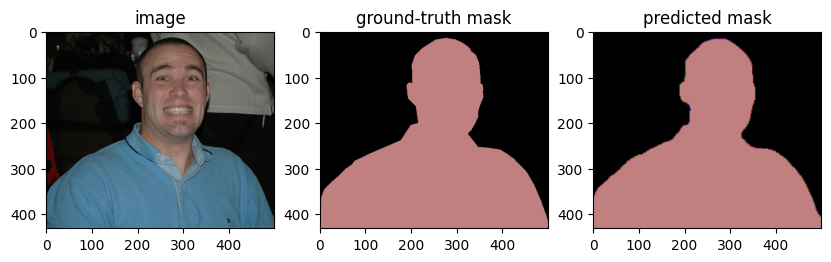

In [30]:
idx = random.randint(0, 200)
img, groundtruth_mask = test_dataset.__getitem__(idx)
predicted_mask = predictor.predict(img)
visualize(img, groundtruth_mask, predicted_mask, color_map = VOC_COLORMAP)


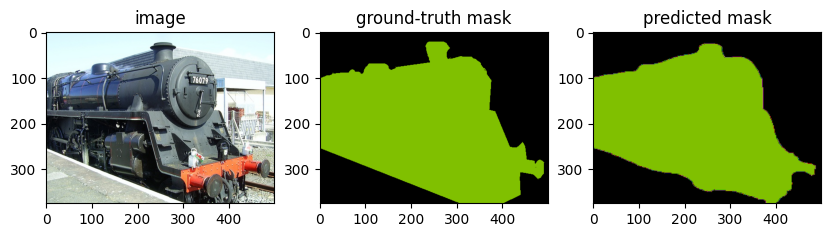

In [33]:
idx = random.randint(0, 200)
img, groundtruth_mask = test_dataset.__getitem__(idx)
predicted_mask = predictor.predict(img)
visualize(img, groundtruth_mask, predicted_mask, color_map = VOC_COLORMAP)
